# Discrete Event Simulation for MRI scheduling policies
### Goal:
•⁠  Compare two separate facilities for each patient type to combined facilities for both types.

•⁠  Generate arrival times for both types

•⁠  Schedule for first possible slot this is where the systems differ

•⁠  Generate duration of appointment

### KPIs:

•⁠  ⁠Expected Wait time (time between call and scheduled slot)

•⁠  ⁠Unexpected wait time (time that patients have to wait on the same day due to appointments taking more time) 

•⁠  ⁠Percentage patients with delay bigger than certain value x

•⁠  ⁠Overtime

•⁠  ⁠Utilization of machines

•⁠  ⁠Patients served per day


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import scipy.stats as stats

In [2]:
# Data from Part 1
df_base = pd.read_csv('des_params_summary.csv', index_col=0)

# Input parameters from Part 1
lbda_arrive_1 = df_base.loc['t1_lambda', 'estimate']
mu_serve_1 = df_base.loc['t1_duration_mean', 'estimate']
sd_serve_1 = df_base.loc['t1_duration_sd', 'estimate']
slot_length_1 = df_base.loc['t1_slot_hours', 'estimate']
slot_length_2 = df_base.loc['t2_slot_hours', 'estimate']

START_H = 8.0
END_H = 17.0
WORK_H = END_H - START_H

lbda_per_hour = lbda_arrive_1 / WORK_H

sim_days = 90

rng = np.random.default_rng(seed=42)


## Data inter-arrival times type 2 patients
Loads data of the original sample and creates a set with first arrival times and a set with interarrival times from which we can sample new values.

In [3]:
df = pd.read_csv("ScanRecords.csv")
d2 = df[df["PatientType"] == "Type 2"].copy()
d2["datetime"] = (
    pd.to_datetime(d2["Date"])
    + pd.to_timedelta(d2["Time"], unit="h")
)

d2 = d2.sort_values("datetime").reset_index(drop=True)

d2["day"] = d2["datetime"].dt.date

first_dt = d2.groupby("day")["datetime"].min() # First arrival time per day
day_start = pd.to_datetime(first_dt.index) + pd.to_timedelta(8, unit="h") 
ia_first_PerDay = ((first_dt - day_start).dt.total_seconds() / 3600).to_numpy() # Time of first arrival per day in hours since 8:00

d2["ia_between_min"] = (
    d2.groupby("day")["datetime"]
      .diff()
      .dt.total_seconds() / 3600
)

ia_between_PerDay = (
    d2["ia_between_min"]
    .dropna()
    .to_numpy()
) # Inter-arrival times between patients in hours


## Discrete event study

In [4]:
def gen_type_1_arrs_and_durs(lbda_arr, mu_ser, sd_ser, days, rng):
    for day in range(1, days+1):
        t = 0.0
        while True:
            ia = rng.exponential(scale=1.0 / lbda_arr)
            t += ia
            if t > WORK_H:
                break  
            dur = rng.normal(loc=mu_ser, scale=sd_ser)
            dur = max(dur, 0.01)  # Ensure duration is positive
            yield day, START_H + t, dur, 1

arrivals_1 = gen_type_1_arrs_and_durs(lbda_per_hour, mu_serve_1, sd_serve_1, sim_days, rng)
arrivals_1_df = pd.DataFrame(arrivals_1, columns=['day', 'call_arrival_time', 'service_duration', 'patient_type'])
arrivals_1_df 

,day,call_arrival_time,service_duration,patient_type
0,1,9.276392,0.327381,1
1,1,10.542459,0.520028,1
2,1,10.588348,0.301878,1
3,1,11.336895,0.397779,1
4,1,11.378992,0.345565,1
...,...,...,...,...
1490,90,13.922858,0.443527,1
1491,90,14.615736,0.548975,1
1492,90,16.134582,0.519718,1
1493,90,16.212381,0.606174,1


In [5]:
def gen_type_2_arrs_and_durs(ia_first_PerDay, ia_between_PerDay, durations, days, rng):
    for day in range(1, days + 1):
        t = 0.0
        while True:
            if t == 0.0:
                ia = rng.choice(ia_first_PerDay)
            else:
                ia = rng.choice(ia_between_PerDay)
            t += ia
            if t > WORK_H:
                break
            dur = rng.choice(durations)
            yield day, START_H + t, dur, 2

arrivals_2 = gen_type_2_arrs_and_durs(ia_first_PerDay, ia_between_PerDay, d2["Duration"].to_numpy(), sim_days, rng)
arrivals_2_df = pd.DataFrame(arrivals_2, columns=['day', 'call_arrival_time', 'service_duration', 'patient_type'])
arrivals_2_df


,day,call_arrival_time,service_duration,patient_type
0,1,8.13,0.636930,2
1,1,8.97,0.787652,2
2,1,9.69,0.851018,2
3,1,10.97,0.409910,2
4,1,12.28,0.586692,2
...,...,...,...,...
882,90,13.74,0.664344,2
883,90,14.41,0.916300,2
884,90,15.63,0.381382,2
885,90,16.04,0.916300,2


In [6]:
def combine_arrivals(arrivals_1_df, arrivals_2_df):
    combined_df = pd.concat([arrivals_1_df, arrivals_2_df], ignore_index=True)
    combined_df = combined_df.sort_values(by=['day', 'call_arrival_time']).reset_index(drop=True)
    cols_to_add = ['scheduled_day', 'scheduled_start', 'scheduled_end', 'actual_start', 'actual_end', 'machine_id']
    for col in cols_to_add:
        combined_df[col] = pd.NA
    # combined_df['patient_id'] = combined_df.index + 1
    return combined_df

combined_arrivals_df = combine_arrivals(arrivals_1_df, arrivals_2_df)
combined_arrivals_df

,day,call_arrival_time,service_duration,patient_type,scheduled_day,scheduled_start,scheduled_end,actual_start,actual_end,machine_id
0,1,8.130000,0.636930,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,1,8.970000,0.787652,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,1,9.276392,0.327381,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,1,9.690000,0.851018,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,1,10.542459,0.520028,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...
2377,90,16.040000,0.916300,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2378,90,16.134582,0.519718,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2379,90,16.212381,0.606174,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2380,90,16.447467,0.557760,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [7]:


def schedule_specialized(arrivals_df, slot_length_1, slot_length_2):
    arrivals_df = arrivals_df.copy()
    next_free = {1: {}, 2: {}}

    def get_next_free(machine, day):
        if day not in next_free[machine]:
            next_free[machine][day] = START_H
        return next_free[machine][day]

    for idx, row in arrivals_df.iterrows():
        machine_id = row['patient_type']
        arrivals_df.loc[idx, 'machine_id'] = machine_id
        slot_length = slot_length_1 if row['patient_type'] == 1 else slot_length_2

        # start searching from next working day
        try_day = row['day'] + 1

        while True:
            next_start = get_next_free(machine_id, try_day)

            # if it fits in the working day, schedule it
            if next_start + slot_length <= END_H:
                arrivals_df.loc[idx, 'scheduled_day'] = try_day
                arrivals_df.loc[idx, 'scheduled_start'] = next_start
                arrivals_df.loc[idx, 'scheduled_end'] = next_start + slot_length
                next_free[machine_id][try_day] = arrivals_df.loc[idx, 'scheduled_end']

                # determine actual start and end times
                # if scheduled start is at beginning of day, use arrival time
                if next_start == 8.0:
                    arrivals_df.loc[idx, 'actual_start'] = next_start
                    arrivals_df.loc[idx, 'actual_end'] = next_start + row['service_duration']
                
                else:
                    # find previous patient on same machine
                    i = 1
                    while True:
                        if arrivals_df.loc[idx - i, 'machine_id'] == machine_id:
                            break
                        i += 1

                    # if previous patient's end time is after scheduled start time, start after that
                    if arrivals_df.loc[idx-i, 'actual_end'] > next_start:
                        arrivals_df.loc[idx, 'actual_start'] = arrivals_df.loc[idx-i, 'actual_end']
                        arrivals_df.loc[idx, 'actual_end'] = arrivals_df.loc[idx-i, 'actual_end'] + row['service_duration']

                    # otherwise, use scheduled start time 
                    else:
                        arrivals_df.loc[idx, 'actual_start'] = next_start
                        arrivals_df.loc[idx, 'actual_end'] = next_start + row['service_duration']
                break

            # otherwise, try next day
            else:
                try_day += 1
                
    return arrivals_df


spec_df = schedule_specialized(combined_arrivals_df, slot_length_1, slot_length_2)
spec_df

,day,call_arrival_time,service_duration,patient_type,scheduled_day,scheduled_start,scheduled_end,actual_start,actual_end,machine_id
0,1,8.130000,0.636930,2,2,8.0,9.0,8.0,8.63693,2
1,1,8.970000,0.787652,2,2,9.0,10.0,9.0,9.787652,2
2,1,9.276392,0.327381,1,2,8.0,8.583333,8.0,8.327381,1
3,1,9.690000,0.851018,2,2,10.0,11.0,10.0,10.851018,2
4,1,10.542459,0.520028,1,2,8.583333,9.166667,8.583333,9.103361,1
...,...,...,...,...,...,...,...,...,...,...
2377,90,16.040000,0.916300,2,100,11.0,12.0,11.0,11.9163,2
2378,90,16.134582,0.519718,1,101,12.083333,12.666667,12.083333,12.603051,1
2379,90,16.212381,0.606174,1,101,12.666667,13.25,12.666667,13.272841,1
2380,90,16.447467,0.557760,1,101,13.25,13.833333,13.272841,13.830601,1


In [8]:
def schedule_mixed(arrivals_df, slot_length_1, slot_length_2):
    arrivals_df = arrivals_df.copy()
    next_free = {1: {}, 2: {}}

    def get_next_free(machine, day):
        if day not in next_free[machine]:
            next_free[machine][day] = START_H
        return next_free[machine][day]

    for idx, row in arrivals_df.iterrows():
        slot_length = slot_length_1 if row['patient_type'] == 1 else slot_length_2

        # start searching from next working day
        try_day = row['day'] + 1

        while True:
            next_start_m1 = get_next_free(1, try_day)
            next_start_m2 = get_next_free(2, try_day)

            if next_start_m1 <= next_start_m2:
                machine_id, next_start = 1, next_start_m1
            else:
                machine_id, next_start = 2, next_start_m2

            # if it fits in the working day, schedule it
            if next_start + slot_length <= END_H:
                arrivals_df.loc[idx, 'scheduled_day'] = try_day
                arrivals_df.loc[idx, 'scheduled_start'] = next_start
                arrivals_df.loc[idx, 'scheduled_end'] = next_start + slot_length
                arrivals_df.loc[idx, 'machine_id'] = machine_id
                next_free[machine_id][try_day] = arrivals_df.loc[idx, 'scheduled_end']
                break

            # otherwise, try next day
            else:
                try_day += 1
        
        
    # Needed a second pass because type 1 patients could be scheduled before type 2 patients due to shorter slots
    # Don't need this for specialized scheduling since patients are scheduled in order of arrival per machine

    # Sort by scheduled day, machine, and start time
    scheduled_order = arrivals_df.sort_values(
        by=['scheduled_day', 'machine_id', 'scheduled_start']
    ).index

    # Track last actual_end per (day, machine)
    last_end = {}  # key: (scheduled_day, machine_id) -> actual_end

    for idx in scheduled_order:
        row = arrivals_df.loc[idx]
        day = row['scheduled_day']
        machine = row['machine_id']
        sched_start = row['scheduled_start']
        duration = row['service_duration']

        key = (day, machine)
        prev_end = last_end.get(key, START_H)

        # Actual start is the later of scheduled start or previous patient's end
        actual_start = max(sched_start, prev_end)
        actual_end = actual_start + duration

        arrivals_df.loc[idx, 'actual_start'] = actual_start
        arrivals_df.loc[idx, 'actual_end'] = actual_end

        last_end[key] = actual_end

    return arrivals_df

mix_df = schedule_mixed(combined_arrivals_df, slot_length_1, slot_length_2)
mix_df

,day,call_arrival_time,service_duration,patient_type,scheduled_day,scheduled_start,scheduled_end,actual_start,actual_end,machine_id
0,1,8.130000,0.636930,2,2,8.0,9.0,8.0,8.63693,1
1,1,8.970000,0.787652,2,2,8.0,9.0,8.0,8.787652,2
2,1,9.276392,0.327381,1,2,9.0,9.583333,9.0,9.327381,1
3,1,9.690000,0.851018,2,2,9.0,10.0,9.0,9.851018,2
4,1,10.542459,0.520028,1,2,9.583333,10.166667,9.583333,10.103361,1
...,...,...,...,...,...,...,...,...,...,...
2377,90,16.040000,0.916300,2,103,8.0,9.0,8.0,8.9163,2
2378,90,16.134582,0.519718,1,102,16.083333,16.666667,16.083333,16.603051,2
2379,90,16.212381,0.606174,1,102,16.25,16.833333,16.25,16.856174,1
2380,90,16.447467,0.557760,1,103,9.0,9.583333,9.0,9.55776,1


In [9]:
def calc_kpis (schedule, sched_type=None, visualize=False):
    schedule = schedule.copy()

    # waiting time in working hours
    schedule['waiting_time_workh'] = (
        (schedule["scheduled_day"].astype(int) - schedule["day"].astype(int)) * 9.0
        + (schedule["scheduled_start"].astype(float) - schedule["call_arrival_time"].astype(float))
    ) 
    # total waiting time in hours
    schedule['waiting_time_total'] = (
        (schedule["scheduled_day"].astype(int) - schedule["day"].astype(int)) * 24.0
        + (schedule["scheduled_start"].astype(float) - schedule["call_arrival_time"].astype(float))
    ) 

    # unexpected waiting time in hours
    schedule['unexpected_waiting_time'] = schedule['actual_start'] - schedule['scheduled_start']

    # waiting times in days
    schedule['waiting_time_days'] = schedule["scheduled_day"].astype(int) - schedule["day"].astype(int)

    # overtime in hours
    overtime = (schedule.groupby(['scheduled_day', 'machine_id'])['actual_end']
                .max()
                .apply(lambda x: max(0, x - END_H))
                .rename('overtime_h')
                .reset_index())
    
    # patients served per day
    patients_per_day = (schedule.groupby(['scheduled_day'])
                        .size()
                        .rename('patients_served_total')
                        .reset_index(drop=True))
    
    # utilization per machine per day
    utilization = (schedule.groupby(['scheduled_day', 'machine_id'])['service_duration']
                         .sum()
                         .apply(lambda x: x / WORK_H)
                         .rename('utilization')
                         .reset_index())
    
    # --- Visualizations ---
    if visualize:
            sns.histplot(schedule['waiting_time_days'], bins=range(0, schedule['waiting_time_days'].max()+2), kde=False)
            plt.title(f'Distribution of Waiting Times (Days) for {sched_type} scheduling')
            plt.xlabel('Waiting Time (Days)')
            plt.ylabel('Number of Patients')
            plt.savefig(f'{sched_type}_waiting_time_distribution.png')
            plt.clf()

            sns.lineplot(data=schedule, x='day', y='waiting_time_days', errorbar='sd')
            plt.title(f'Average Waiting Time (Days) by Call Day for {sched_type} scheduling')
            plt.xlabel('Call Day') 
            plt.ylabel('Average Waiting Time (Days)')
            plt.savefig(f'{sched_type}_avg_waiting_time_days.png')
            plt.clf()

            sns.lineplot(data=schedule, x='day', y='waiting_time_workh', errorbar='sd')
            plt.title(f'Average Waiting Time (Work Hours) by Call Day for {sched_type} scheduling')
            plt.xlabel('Call Day') 
            plt.ylabel('Average Waiting Time (Work Hours)')
            plt.savefig(f'{sched_type}_avg_waiting_time_hours.png')
            plt.clf()   

            sns.histplot(schedule['unexpected_waiting_time']*60, bins=30, kde=False)
            plt.title(f'Distribution of Unexpected Waiting Times (Minutes) for {sched_type} scheduling')
            plt.xlabel('Unexpected Waiting Time (Minutes)')
            plt.ylabel('Number of Patients')
            plt.savefig(f'{sched_type}_unexpected_waiting_time_distribution.png')
            plt.clf()

    # --- Summary Statistics ---
    summary = {}
    
    # 1. Waiting time (days) - patient perspective
    wt_days = schedule['waiting_time_days']
    summary['wait_days_mean'] = wt_days.mean()
    summary['wait_days_median'] = wt_days.median()
    summary['wait_days_std'] = wt_days.std()
    summary['wait_days_p90'] = wt_days.quantile(0.90)
    summary['wait_days_p95'] = wt_days.quantile(0.95)
    summary['wait_days_max'] = wt_days.max()
    summary['pct_wait_over_3days'] = (wt_days > 3).mean() * 100
    summary['pct_wait_over_7days'] = (wt_days > 7).mean() * 100
    
    # 2. Unexpected waiting time (same-day delays)
    uwt = schedule['unexpected_waiting_time']
    summary['unexpected_wait_mean'] = uwt.mean()
    summary['unexpected_wait_std'] = uwt.std()
    summary['unexpected_wait_p90'] = uwt.quantile(0.90)
    summary['unexpected_wait_max'] = uwt.max()
    summary['pct_patients_delayed'] = (uwt > 0.01).mean() * 100  # >0.6 min delay
    summary['pct_delay_over_15min'] = (uwt > 0.25).mean() * 100
    summary['pct_delay_over_30min'] = (uwt > 0.5).mean() * 100
    
    # 3. Overtime - staff/operations perspective
    ot = overtime['overtime_h']
    summary['overtime_mean'] = ot.mean()
    summary['overtime_total'] = ot.sum()
    summary['overtime_max'] = ot.max()
    summary['pct_days_with_overtime'] = (ot > 0).mean() * 100
    
    # 4. Utilization - efficiency perspective
    util = utilization['utilization']
    summary['utilization_mean'] = util.mean()
    summary['utilization_std'] = util.std()
    summary['utilization_min'] = util.min()
    summary['utilization_max'] = util.max()
    
    # 5. Throughput
    summary['patients_per_day_mean'] = patients_per_day.mean()
    summary['patients_per_day_std'] = patients_per_day.std()
    summary['total_patients'] = len(schedule)
    
    # By patient type
    for ptype in [1, 2]:
        subset = schedule[schedule['patient_type'] == ptype]
        summary[f'type{ptype}_wait_days_mean'] = subset['waiting_time_days'].mean()
        summary[f'type{ptype}_wait_days_p90'] = subset['waiting_time_days'].quantile(0.90)
        summary[f'type{ptype}_unexpected_wait_mean'] = subset['unexpected_waiting_time'].mean()
    
    return pd.Series(summary)

kpi_mix = calc_kpis(mix_df, sched_type="mixed", visualize=True)
kpi_spec = calc_kpis(spec_df, sched_type="specialized", visualize=True)
pd.concat([kpi_mix, kpi_spec], axis=1, keys=['Mixed Scheduling', 'Specialized Scheduling'])

,Mixed Scheduling,Specialized Scheduling
wait_days_mean,6.711167,5.656171
wait_days_median,7.000000,6.000000
wait_days_std,3.064153,2.454577
wait_days_p90,11.000000,9.000000
wait_days_p95,12.000000,10.000000
wait_days_max,13.000000,11.000000
pct_wait_over_3days,79.638959,76.742233
pct_wait_over_7days,41.309824,22.334173
unexpected_wait_mean,0.005491,0.004114
unexpected_wait_std,0.032088,0.026165


<Figure size 640x480 with 0 Axes>

In [10]:
def try_with_diff_slots(lbda_per_hour, mu_serve_1, sd_serve_1, ia_first_PerDay, ia_between_PerDay, dur2, days, slot_length_1, slot_length_2, rng, visualize = False):
    arrivals_1 = gen_type_1_arrs_and_durs(lbda_per_hour, mu_serve_1, sd_serve_1, days, rng)
    arrivals_1_df = pd.DataFrame(arrivals_1, columns=['day', 'call_arrival_time', 'service_duration', 'patient_type'])

    arrivals_2 = gen_type_2_arrs_and_durs(ia_first_PerDay, ia_between_PerDay, dur2, days, rng)
    arrivals_2_df = pd.DataFrame(arrivals_2, columns=['day', 'call_arrival_time', 'service_duration', 'patient_type'])

    combined_arrivals_df = combine_arrivals(arrivals_1_df, arrivals_2_df)

    mix_df = schedule_mixed(combined_arrivals_df, slot_length_1, slot_length_2)
    spec_df = schedule_specialized(combined_arrivals_df, slot_length_1, slot_length_2)

    kpi_mix = calc_kpis(mix_df, sched_type="ALT_SLOT_LENGTH_mixed", visualize=visualize)
    kpi_spec = calc_kpis(spec_df, sched_type="ALT_SLOT_LENGTH_specialized", visualize=visualize)

    return pd.concat([kpi_mix, kpi_spec], axis=1, keys=['Mixed Scheduling', 'Specialized Scheduling'])

# Sensitivity analysis: Compare different slot lengths for Type 1 (25, 30 min) and Type 2 (45, 50 min)
# Slot lengths in hours
slot_configs = [
    (25/60, 45/60, "(25/45)"),
    (25/60, 50/60, "(25/50)"),
    (30/60, 45/60, "(30/45)"),
    (30/60, 50/60, "(30/50)"),
]

# Run simulations for each configuration
results_list = []
for slot1, slot2, label in slot_configs:
    rng_config = np.random.default_rng(seed=42)  # Reset seed for fair comparison
    kpis = try_with_diff_slots(
        lbda_per_hour, mu_serve_1, sd_serve_1, 
        ia_first_PerDay, ia_between_PerDay, 
        d2["Duration"].to_numpy(), 
        sim_days,  # Use same number of days as main simulation
        slot1, slot2, 
        rng_config
    )
    kpis.rename(columns=lambda x: f"{x} {label}", inplace=True)
    results_list.append(kpis)

# Combine results
all_results = pd.concat(results_list, axis=1)
all_results.to_latex('sensitivity_analysis_results.tex')
all_results

,Mixed Scheduling (25/45),Specialized Scheduling (25/45),Mixed Scheduling (25/50),Specialized Scheduling (25/50),Mixed Scheduling (30/45),Specialized Scheduling (30/45),Mixed Scheduling (30/50),Specialized Scheduling (30/50)
wait_days_mean,1.002519,1.018052,1.011335,1.107473,1.018892,1.110411,1.083963,1.199832
wait_days_median,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
wait_days_std,0.050136,0.133168,0.105883,0.309778,0.136171,0.313468,0.277391,0.399958
wait_days_p90,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,2.000000
wait_days_p95,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000
wait_days_max,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
pct_wait_over_3days,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pct_wait_over_7days,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
unexpected_wait_mean,0.155218,0.172136,0.102451,0.150047,0.060436,0.056379,0.034602,0.034289
unexpected_wait_std,0.209514,0.214812,0.153316,0.209634,0.122594,0.126978,0.082552,0.093858


In [11]:
alt_slot_length_1 = 30/60
alt_slot_length_2 = 50/60

alt_kpis = try_with_diff_slots(lbda_per_hour, mu_serve_1, sd_serve_1, ia_first_PerDay, ia_between_PerDay, d2["Duration"].to_numpy(), sim_days, alt_slot_length_1, alt_slot_length_2, rng, visualize=True)
alt_kpis

,Mixed Scheduling,Specialized Scheduling
wait_days_mean,1.179967,1.500000
wait_days_median,1.000000,1.000000
wait_days_std,0.384239,0.550504
wait_days_p90,2.000000,2.000000
wait_days_p95,2.000000,2.000000
wait_days_max,2.000000,3.000000
pct_wait_over_3days,0.000000,0.000000
pct_wait_over_7days,0.000000,0.000000
unexpected_wait_mean,0.036133,0.030941
unexpected_wait_std,0.090556,0.078044


<Figure size 640x480 with 0 Axes>

## Bootstrap DES integration

In [13]:
df_boot = pd.read_csv('des_bootstrap_params.csv', index_col=0)
df_params = df_boot[['t1_lambda', 't1_duration_mean', 't1_duration_sd']].rename(
    columns={
        't1_lambda': 'lbda_arrive',
        't1_duration_mean': 'mu_serve',
        't1_duration_sd': 'sd_serve'
    }
)
df_params['lbda_arrive'] = df_params['lbda_arrive'] / WORK_H  # per hour

slot_length_1 = 30/60
slot_length_2 = 50/60

def run_sim(row, ia_first_PerDay, ia_between_PerDay, dur2, warmup_days, sim_days, slot_length_1, slot_length_2, rng):
    arrivals_1 = gen_type_1_arrs_and_durs(row.lbda_arrive, row.mu_serve, row.sd_serve, sim_days, rng)
    arrivals_1_df = pd.DataFrame(arrivals_1, columns=['day', 'call_arrival_time', 'service_duration', 'patient_type'])
    arrivals_1_df = arrivals_1_df[arrivals_1_df['day'] > warmup_days].reset_index(drop=True)

    arrivals_2 = gen_type_2_arrs_and_durs(ia_first_PerDay, ia_between_PerDay, dur2, sim_days, rng)
    arrivals_2_df = pd.DataFrame(arrivals_2, columns=['day', 'call_arrival_time', 'service_duration', 'patient_type'])
    arrivals_2_df = arrivals_2_df[arrivals_2_df['day'] > warmup_days].reset_index(drop=True)

    combined_arrivals_df = combine_arrivals(arrivals_1_df, arrivals_2_df)

    mix_df = schedule_mixed(combined_arrivals_df, slot_length_1, slot_length_2)
    spec_df = schedule_specialized(combined_arrivals_df, slot_length_1, slot_length_2)

    kpi_mix = calc_kpis(mix_df, visualize=False)
    kpi_spec = calc_kpis(spec_df, visualize=False)

    return kpi_mix, kpi_spec

# Run in parallel
dur2 = d2["Duration"].to_numpy()
results = Parallel(n_jobs=-1)(
    delayed(run_sim)(
        row, ia_first_PerDay, ia_between_PerDay, dur2, 5, 21, 
        slot_length_1, slot_length_2, rng
    )
    for i, row in enumerate(df_params.itertuples())
) # run all parameter sets in parallel

kpi_mix_list, kpi_spec_list = zip(*results)
kpi_mix_df = pd.DataFrame(kpi_mix_list)
kpi_spec_df = pd.DataFrame(kpi_spec_list)


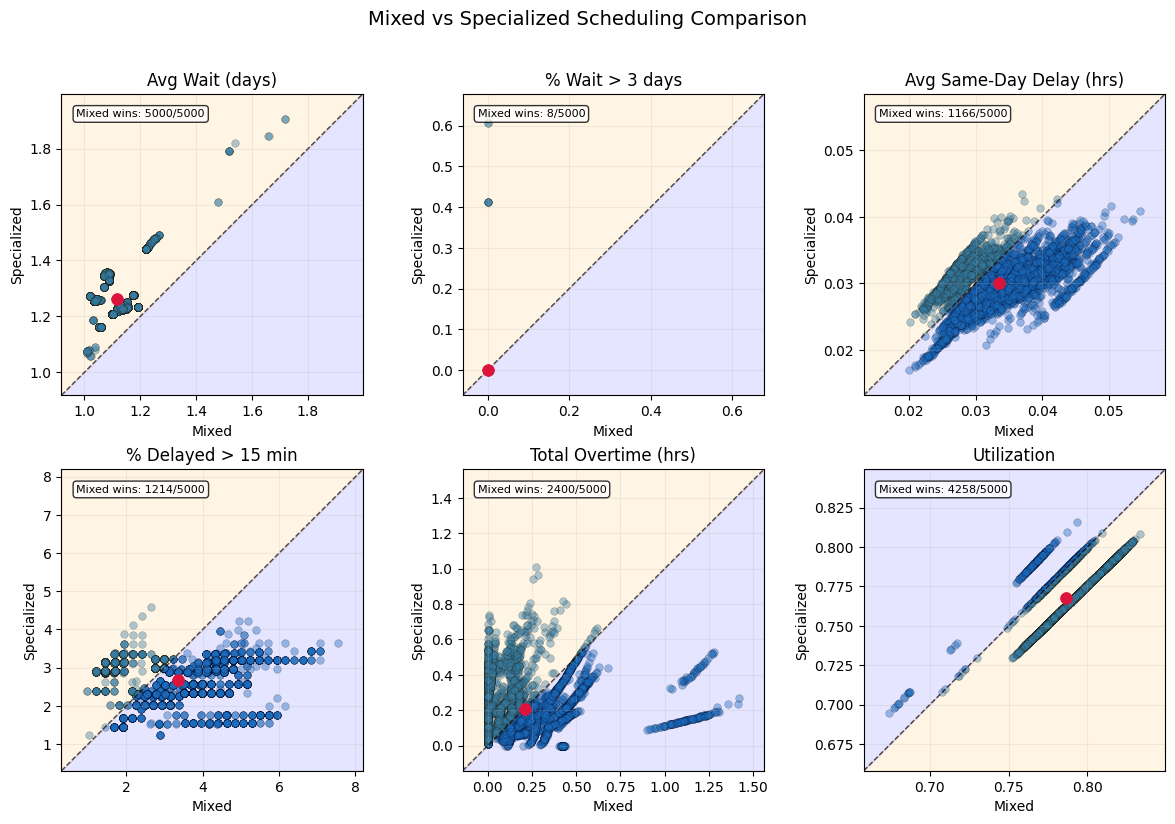

In [14]:
def calc_ci(data, confidence=0.95):
    """Calculate mean and confidence interval."""
    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)
    ci = se * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean, ci

def plot_key_metrics_matrix(kpi_mix_df, kpi_spec_df, figsize=(12, 8)):
    """Focused 2x3 matrix of key metrics."""
    
    key_kpis = [
        ('wait_days_mean', 'Avg Wait (days)', 'lower'),
        ('pct_wait_over_3days', '% Wait > 3 days', 'lower'),
        ('unexpected_wait_mean', 'Avg Same-Day Delay (hrs)', 'lower'),
        ('pct_delay_over_15min', '% Delayed > 15 min', 'lower'),
        ('overtime_total', 'Total Overtime (hrs)', 'lower'),
        ('utilization_mean', 'Utilization', 'higher')
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()
    
    for i, (kpi, label, better) in enumerate(key_kpis):
        ax = axes[i]
        
        mix_vals = kpi_mix_df[kpi].values
        spec_vals = kpi_spec_df[kpi].values
        
        # Scatter
        ax.scatter(mix_vals, spec_vals, alpha=0.4, edgecolor='k', linewidth=0.3, s=30)
        
        # Diagonal
        all_vals = np.concatenate([mix_vals, spec_vals])
        min_val, max_val = np.min(all_vals), np.max(all_vals)
        margin = (max_val - min_val) * 0.1
        line_range = [min_val - margin, max_val + margin]
        ax.plot(line_range, line_range, 'k--', linewidth=1, alpha=0.7)
        
        # Mean with CI
        mix_mean, mix_ci = calc_ci(mix_vals)
        spec_mean, spec_ci = calc_ci(spec_vals)
        ax.errorbar(mix_mean, spec_mean, xerr=mix_ci, yerr=spec_ci,
                    fmt='o', color='crimson', markersize=8, capsize=4, zorder=5)
        
        # Shade the "better" region
        if better == 'lower':
            # Below diagonal = mixed better
            ax.fill_between(line_range, line_range, line_range[0], 
                           alpha=0.1, color='blue', label='Mixed better')
            ax.fill_between(line_range, line_range, line_range[1],
                           alpha=0.1, color='orange', label='Specialized better')
        else:
            # Above diagonal = mixed better (for utilization)
            ax.fill_between(line_range, line_range, line_range[1], 
                           alpha=0.1, color='blue')
            ax.fill_between(line_range, line_range, line_range[0],
                           alpha=0.1, color='orange')
        
        ax.set_xlim(line_range)
        ax.set_ylim(line_range)
        ax.set_xlabel('Mixed')
        ax.set_ylabel('Specialized')
        ax.set_title(label)
        ax.set_aspect('equal', adjustable='box')
        ax.grid(alpha=0.2)
        
        # Win count
        if better == 'lower':
            n_mix_wins = np.sum(mix_vals < spec_vals)
        else:
            n_mix_wins = np.sum(mix_vals > spec_vals)
        n_total = len(mix_vals)
        ax.text(0.05, 0.95, f'Mixed wins: {n_mix_wins}/{n_total}',
                transform=ax.transAxes, fontsize=8, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle('Mixed vs Specialized Scheduling Comparison', fontsize=14, y=1.02)
    plt.tight_layout()
    return fig

fig = plot_key_metrics_matrix(kpi_mix_df, kpi_spec_df)
plt.savefig('key_metrics_comparison.png', dpi=150, bbox_inches='tight')

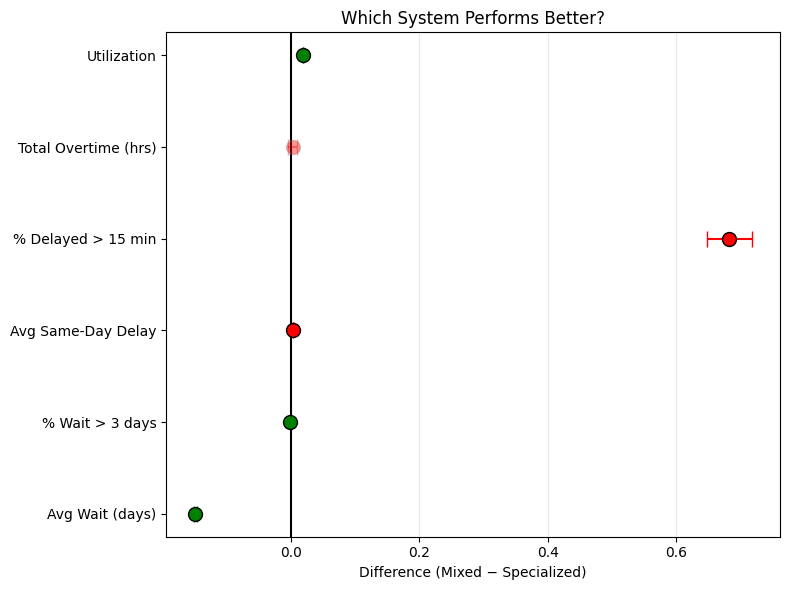

In [15]:
def plot_summary_differences(kpi_mix_df, kpi_spec_df, figsize=(8, 6)):
    """
    Forest-style plot showing differences with CIs.
    Clearly shows which system wins on each metric.
    """
    key_kpis = [
        ('wait_days_mean', 'Avg Wait (days)', 'lower'),
        ('pct_wait_over_3days', '% Wait > 3 days', 'lower'),
        ('unexpected_wait_mean', 'Avg Same-Day Delay', 'lower'),
        ('pct_delay_over_15min', '% Delayed > 15 min', 'lower'),
        ('overtime_total', 'Total Overtime (hrs)', 'lower'),
        ('utilization_mean', 'Utilization', 'higher')
    ]
    
    fig, ax = plt.subplots(figsize=figsize)
    
    y_positions = np.arange(len(key_kpis))
    
    for i, (kpi, label, better) in enumerate(key_kpis):
        # Calculate difference
        diff = kpi_mix_df[kpi].values - kpi_spec_df[kpi].values
        diff_mean, diff_ci = calc_ci(diff)
        
        # Determine color: green if mixed is better, red if specialized is better
        if better == 'lower':
            color = 'green' if diff_mean < 0 else 'red'
        else:
            color = 'green' if diff_mean > 0 else 'red'
        
        # Check significance (CI doesn't cross zero)
        significant = not (diff_mean - diff_ci < 0 < diff_mean + diff_ci)
        marker = 'o' if significant else 'o'
        alpha = 1.0 if significant else 0.4
        
        ax.errorbar(diff_mean, i, xerr=diff_ci, fmt=marker,
                    color=color, capsize=6, markersize=10, alpha=alpha,
                    markeredgecolor='black' if significant else 'gray',
                    markeredgewidth=1)
    
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
    ax.set_yticks(y_positions)
    ax.set_yticklabels([label for _, label, _ in key_kpis])
    ax.set_xlabel('Difference (Mixed − Specialized)')
    ax.set_title('Which System Performs Better?')
    
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    return fig

fig = plot_summary_differences(kpi_mix_df, kpi_spec_df)
plt.savefig('summary_differences.png', dpi=150, bbox_inches='tight')

In [16]:
def create_final_summary_table(kpi_mix_df, kpi_spec_df):
    """Clean summary table for report/paper."""
    
    key_kpis = [
        ('wait_days_mean', 'Avg Wait (days)', 'lower'),
        ('pct_wait_over_3days', '% Wait > 3 days', 'lower'),
        ('unexpected_wait_mean', 'Avg Same-Day Delay (hrs)', 'lower'),
        ('pct_delay_over_15min', '% Delayed > 15 min', 'lower'),
        ('overtime_total', 'Total Overtime (hrs)', 'lower'),
        ('utilization_mean', 'Utilization (%)', 'higher')
    ]
    
    rows = []
    for kpi, label, better in key_kpis:
        mix_mean, mix_ci = calc_ci(kpi_mix_df[kpi])
        spec_mean, spec_ci = calc_ci(kpi_spec_df[kpi])
        
        diff = kpi_mix_df[kpi].values - kpi_spec_df[kpi].values
        diff_mean, diff_ci = calc_ci(diff)
        
        # Paired t-test
        t_stat, p_value = stats.ttest_rel(kpi_mix_df[kpi], kpi_spec_df[kpi])
        
        # Determine winner
        if p_value < 0.05:
            if better == 'lower':
                winner = 'Mixed' if diff_mean < 0 else 'Specialized'
            else:
                winner = 'Mixed' if diff_mean > 0 else 'Specialized'
        else:
            winner = 'No difference'
        
        rows.append({
            'Metric': label,
            'Mixed': f'{mix_mean:.2f} ± {mix_ci:.2f}',
            'Specialized': f'{spec_mean:.2f} ± {spec_ci:.2f}',
            'Δ (Mix - Spec)': f'{diff_mean:+.2f}',
            'p-value': f'{p_value:.3f}',
            'Better': winner
        })
    
    return pd.DataFrame(rows)

summary = create_final_summary_table(kpi_mix_df, kpi_spec_df)
print(summary.to_string(index=False))
summary.to_csv('final_comparison_summary.csv', index=False)

                  Metric       Mixed Specialized Δ (Mix - Spec) p-value        Better
         Avg Wait (days) 1.12 ± 0.00 1.26 ± 0.00          -0.15   0.000         Mixed
         % Wait > 3 days 0.00 ± 0.00 0.00 ± 0.00          -0.00   0.006         Mixed
Avg Same-Day Delay (hrs) 0.03 ± 0.00 0.03 ± 0.00          +0.00   0.000   Specialized
      % Delayed > 15 min 3.36 ± 0.03 2.68 ± 0.01          +0.68   0.000   Specialized
    Total Overtime (hrs) 0.21 ± 0.01 0.21 ± 0.00          +0.00   0.404 No difference
         Utilization (%) 0.79 ± 0.00 0.77 ± 0.00          +0.02   0.000         Mixed
